## Problem Description
This is a binary image classification problem where we are tasked with identifying metastatic cancer in small image patches taken from larger digital pathology scans.
The data for this kaggle mini-project is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images
due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates).

PCam is highly interesting for both its size, simplicity to get started on, and approachability

The basic problem statement is as follows:

The center region (32x32 pixels) of each image patch determines its classification:


* **1 (positive):** At least one tumor pixel in the center
* **0 (negative):** No tumor pixels in the center, even if present in the outer regions


We must predict probabilities for the test dataset and submit results in the required format for evaluation

**Evaluation Criteria:** Submissions are scored using the Area Under the Receiver Operating Characteristic Curve (ROC AUC), emphasizing the model's ability to rank predictions correctly.

This Notebook is also available on github at below link:
[https://github.com/himanshudongre/Kaggle-CNN-Cancer-Detection.git](http://)

## Dataset Description

In this dataset, you are provided with a large number of small pathology images to classify. The dataset provided in this competition is derived from the PatchCamelyon (PCam) benchmark dataset. The original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates.


* Training Data:
    * Images: Located in the **/train** directory, each image is a small 32x32 RGB patch.
    * Labels: A CSV file (train_labels.csv) maps each image ID to a binary label (1 or 0).

* Test Data:
    * Images: Located in the **/test** directory, these patches are unlabeled and used for model prediction.
    * Submission: Predictions are uploaded in CSV format with columns id and label.

Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

This dataset is available at below link:
[https://www.kaggle.com/competitions/histopathologic-cancer-detection/data](http://)

In [1]:
# Importing necessary libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, random_split, DataLoader
import torch

## Exploratory Data Analysis (EDA)

In [2]:
# Load the dataset
train_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

# Display the first few rows of the training labels
print("Training Labels:")
print(train_labels.head())

# Check the number of images in the dataset
print(f"Total images in training set: {len(train_labels)}")

Training Labels:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
Total images in training set: 220025


Sample Cancerous Images:


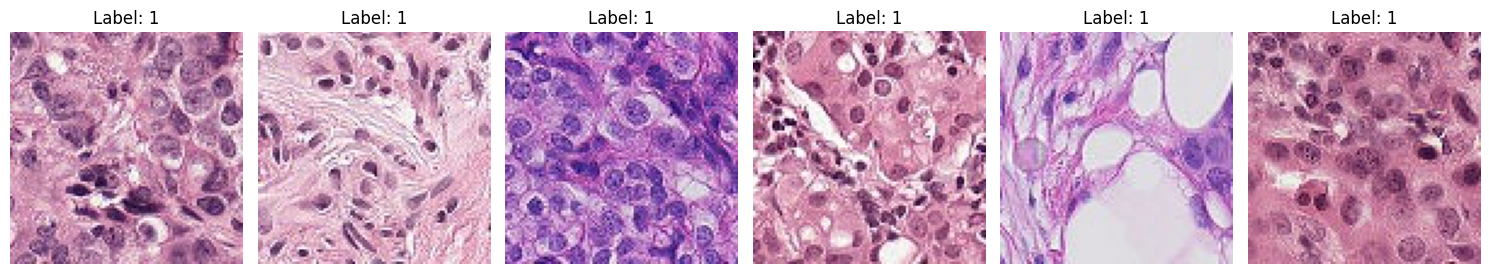

Sample Non-Cancerous Images:


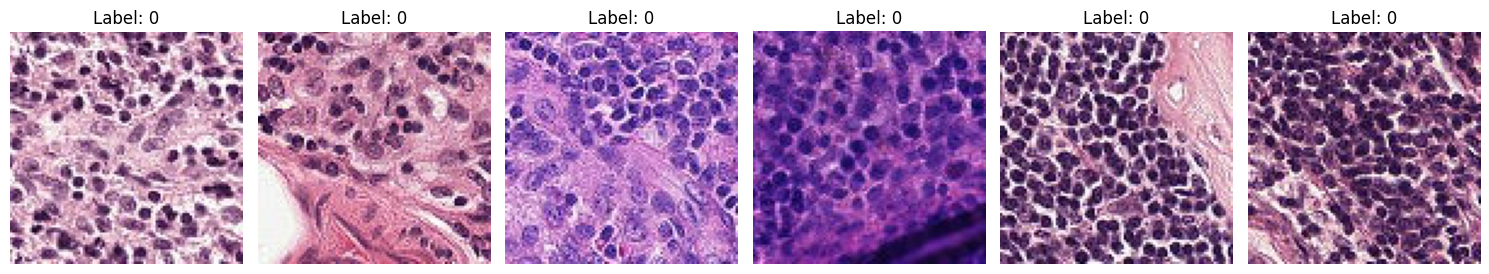

In [3]:
# Visualize some sample images from each class
def display_sample_images(df, label, n=6):
    sample_images = df[df['label'] == label].sample(n)
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    for idx, img_id in enumerate(sample_images['id']):
        img_path = f'/kaggle/input/histopathologic-cancer-detection/train/{img_id}.tif'
        img = plt.imread(img_path)
        axes[idx].imshow(img)
        axes[idx].set_title(f"Label: {label}")
        axes[idx].axis('off')
    plt.tight_layout()
    plt.show()

# Display sample cancerous images
print("Sample Cancerous Images:")
display_sample_images(train_labels, label=1)

# Display sample non-cancerous images
print("Sample Non-Cancerous Images:")
display_sample_images(train_labels, label=0)

In [4]:
# Check for missing values
missing_values = train_labels.isnull().sum()
print(f"Missing Values:\n{missing_values}")

Missing Values:
id       0
label    0
dtype: int64


There are no missing values in the dataset

Next we check for class imbalance. Understanding the distribution of labels (0 for non-cancerous, 1 for cancerous) is crucial. Class imbalance can lead to biased model predictions, favoring the majority class.

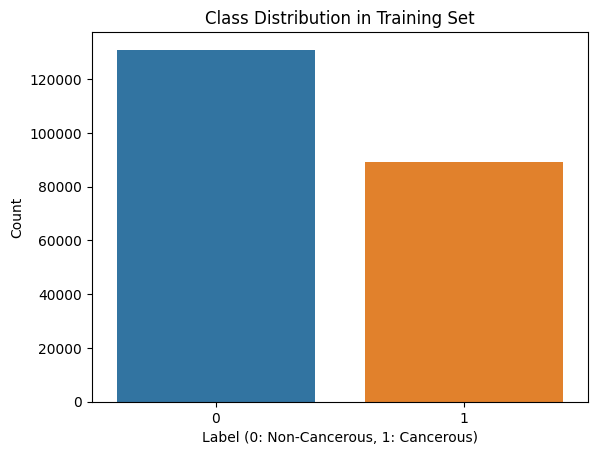

In [5]:
# Class distribution
sns.countplot(x='label', data=train_labels)
plt.title('Class Distribution in Training Set')
plt.xlabel('Label (0: Non-Cancerous, 1: Cancerous)')
plt.ylabel('Count')
plt.show()

Its clear from the above plot that the dataset appears to have a class imbalance, with significantly more non-cancerous (0) samples compared to cancerous (1) ones. This imbalance can lead to biased model training. To address this issue, we will use data augmentation techniques to artificially expand the dataset, especially focusing on the minority class.

Analyzing Pixel Value Distributions:


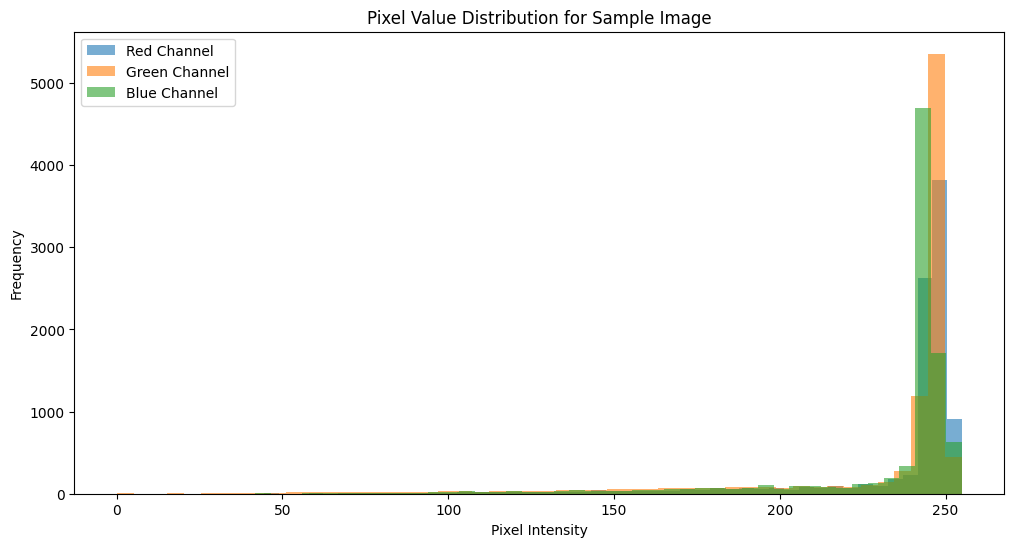

In [6]:
# Analyze pixel value distributions
print("Analyzing Pixel Value Distributions:")
sample_image_path = f"/kaggle/input/histopathologic-cancer-detection/train/{train_labels['id'][0]}.tif"
sample_image = plt.imread(sample_image_path)

# Plot pixel value distributions for each channel (R, G, B)
plt.figure(figsize=(12, 6))
colors = ['Red', 'Green', 'Blue']
for i in range(3):
    plt.hist(sample_image[:, :, i].ravel(), bins=50, alpha=0.6, label=f'{colors[i]} Channel')
plt.title("Pixel Value Distribution for Sample Image")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.show()

The pixel value distribution graph shows that the majority of the pixel values are concentrated at the higher end of the intensity range (around 200-255) for all three channels (Red, Green, and Blue). This indicates that most of the images have bright areas with less variation in pixel intensity.

Normalizing pixel values to a common range can make gradients more stable during training and help the model converge faster.

## Data Preprocessing with Augmentation

To address class imbalance, we apply data augmentation, especially to the minority class. This increases data variability and helps the model generalize better. Normalization ensures consistent input to the model by scaling pixel values.

In [7]:
# Define PyTorch Dataset class
class HistopathologicDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.labels = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.labels.iloc[idx, 0] + ".tif")
        image = Image.open(img_name)
        label = self.labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transformation pipeline with augmentation and normalization
data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.8, 0.8, 0.8], std=[0.2, 0.2, 0.2])  # Normalization
])

# Create the dataset
train_dataset = HistopathologicDataset(
    csv_file='/kaggle/input/histopathologic-cancer-detection/train_labels.csv',
    root_dir='/kaggle/input/histopathologic-cancer-detection/train',
    transform=data_transform
)

# Split into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")

# Define DataLoaders
train_loader = DataLoader(train_data, batch_size=512, shuffle=True, num_workers=4,pin_memory=True)
val_loader = DataLoader(val_data, batch_size=512, shuffle=False, num_workers=4,pin_memory=True)

Training set size: 176020
Validation set size: 44005


Augmented Images for Minority Class:


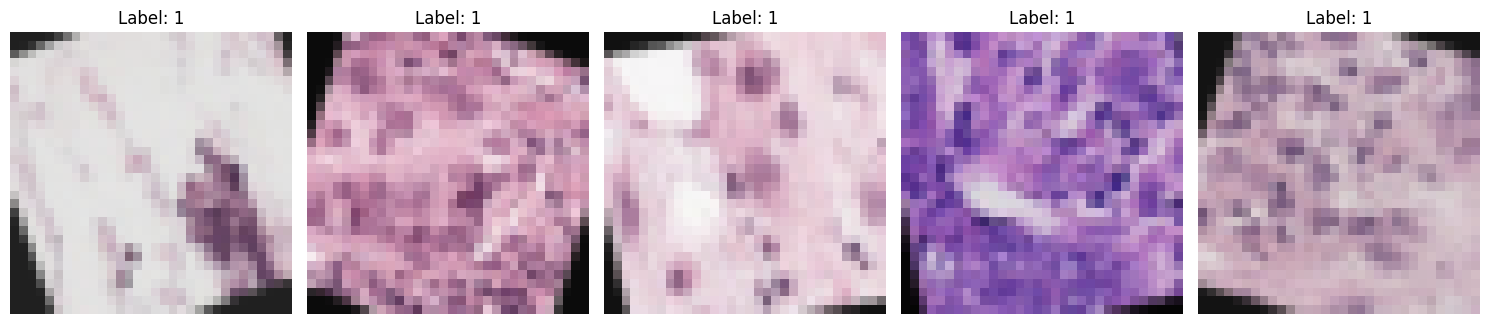

In [8]:
# Visualize augmented images
def show_augmented_images(dataset, n=5):
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    for i in range(n):
        img, label = dataset[i]
        img = img.permute(1, 2, 0).numpy() * 0.2 + 0.8  # Unnormalize for visualization
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Label: {label}")
    plt.tight_layout()
    plt.show()

# Show augmented images for the minority class
minority_class_indices = train_labels[train_labels['label'] == 1].index.tolist()
minority_dataset = torch.utils.data.Subset(train_dataset, minority_class_indices)

print("Augmented Images for Minority Class:")
show_augmented_images(minority_dataset)

## Model Building

**Overall Plan**

The plan is to develop, train, and evaluate three models with increasing complexity:

**Baseline CNN:**

We will start with a simple architecture to establish a reference performance.
This is useful for understanding the dataset and testing the training pipeline.


**Enhanced CNN:**

Next we build on the baseline by introducing depth, regularization (dropout), and Batch Normalization to improve feature extraction and generalization.

**Transfer Learning (ResNet):**

Finally we take a pre-trained ResNet-18 model to leverage external knowledge from ImageNet and fine-tune the network to adapt to histopathological images.

For each model:

* Train the model using a standardized training loop.
* Tune hyperparameters such as learning rates and regularization to optimize performance.
* We compare the models based on validation metrics (e.g., AUC) and summarize the findings.


In [9]:
# Lets start by creating some utility functions that we can utilize for all models

# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Training and evaluation function
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, epochs=10):

    model = model.to(device)
    train_losses, val_losses, val_aucs = [], [], []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        print(f"Epoch {epoch+1}/{epochs} - Training:")
        for batch_idx, (images, labels) in enumerate(train_loader, 1):
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Print progress every 10 batches
            if batch_idx % 10 == 0 or batch_idx == len(train_loader):
                print(f"  Batch {batch_idx}/{len(train_loader)} - Loss: {loss.item():.4f}")
        
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_labels, val_preds = [], []
        print(f"Epoch {epoch+1}/{epochs} - Validation:")
        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(val_loader, 1):
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_labels.extend(labels.cpu().numpy())
                val_preds.extend(torch.sigmoid(outputs).cpu().numpy())

                # Print progress every 10 batches
                if batch_idx % 10 == 0 or batch_idx == len(val_loader):
                    print(f"  Batch {batch_idx}/{len(val_loader)} - Loss: {loss.item():.4f}")
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_auc = roc_auc_score(val_labels, val_preds)
        val_aucs.append(val_auc)
        
        # Summary for the epoch
        print(f"Epoch {epoch+1} Summary:")
        print(f"  Training Loss: {avg_train_loss:.4f}")
        print(f"  Validation Loss: {avg_val_loss:.4f}")
        print(f"  Validation AUC: {val_auc:.4f}\n")
    
    return train_losses, val_losses, val_aucs



# Plotting function
def plot_results(results, title):
    
    train_losses, val_losses, val_aucs = results
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.plot(epochs, val_aucs, label='Validation AUC')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss / AUC')
    plt.legend()
    plt.show()

### Baseline CNN Model

In [10]:
# Define the Baseline CNN model
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Instantiate and print the baseline model
baseline_model = BaselineCNN()
print("Baseline Model Architecture:")
print(baseline_model)

Baseline Model Architecture:
BaselineCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
)


The Baseline CNN is a simple model designed to test the feasibility of solving this problem with a shallow architecture.

**Architecture:**

* Two convolutional layers to extract basic spatial features
* ReLU activation for non-linearity
* MaxPooling layers to reduce spatial dimensions
* Fully connected layers for mapping features to binary outputs

**Reasoning:**
This model is lightweight and computationally efficient and serves as a good starting point for small 32x32 images.
We are following the occum's razor approach of simple is usually the best.


Using device: cuda

Training Baseline Model with learning rate: 0.01
Epoch 1/3 - Training:
  Batch 10/344 - Loss: 0.6858
  Batch 20/344 - Loss: 0.6726
  Batch 30/344 - Loss: 0.6316
  Batch 40/344 - Loss: 0.5958
  Batch 50/344 - Loss: 0.5711
  Batch 60/344 - Loss: 0.5693
  Batch 70/344 - Loss: 0.5300
  Batch 80/344 - Loss: 0.5079
  Batch 90/344 - Loss: 0.4999
  Batch 100/344 - Loss: 0.4916
  Batch 110/344 - Loss: 0.5172
  Batch 120/344 - Loss: 0.4380
  Batch 130/344 - Loss: 0.5093
  Batch 140/344 - Loss: 0.4456
  Batch 150/344 - Loss: 0.4773
  Batch 160/344 - Loss: 0.4444
  Batch 170/344 - Loss: 0.4638
  Batch 180/344 - Loss: 0.4873
  Batch 190/344 - Loss: 0.4128
  Batch 200/344 - Loss: 0.4341
  Batch 210/344 - Loss: 0.4767
  Batch 220/344 - Loss: 0.4788
  Batch 230/344 - Loss: 0.4440
  Batch 240/344 - Loss: 0.4653
  Batch 250/344 - Loss: 0.4656
  Batch 260/344 - Loss: 0.4777
  Batch 270/344 - Loss: 0.4697
  Batch 280/344 - Loss: 0.4302
  Batch 290/344 - Loss: 0.4501
  Batch 300/344 - L

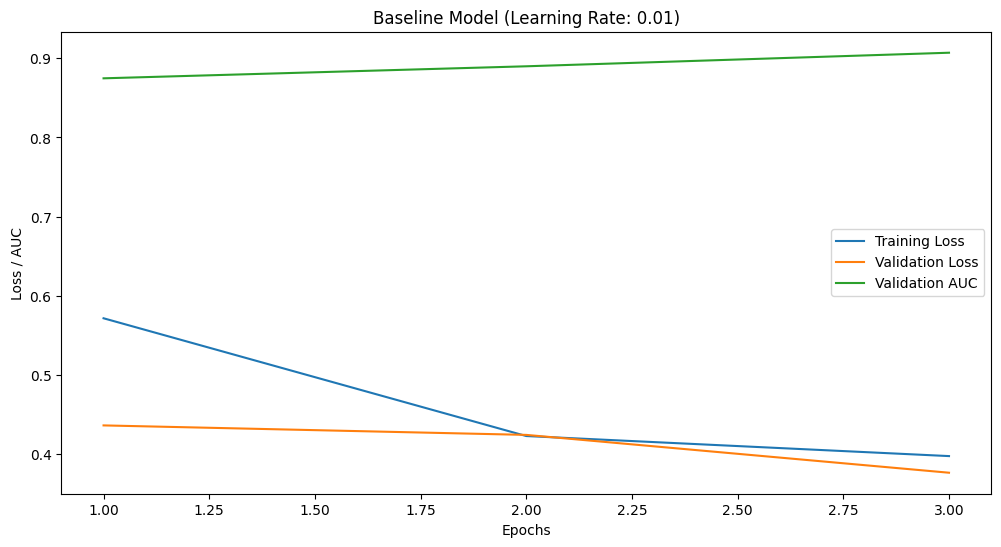


Results for Learning Rate 0.001:


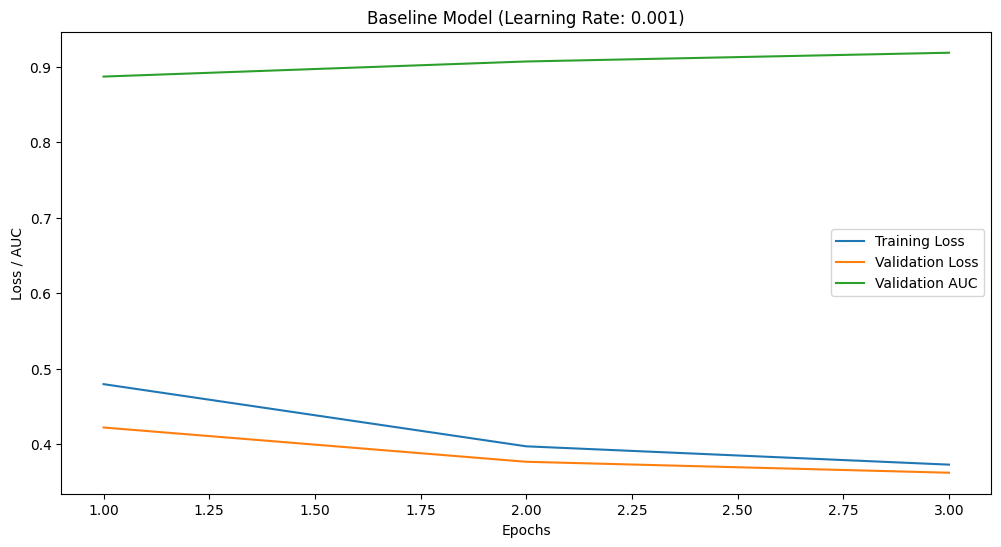


Results for Learning Rate 0.0001:


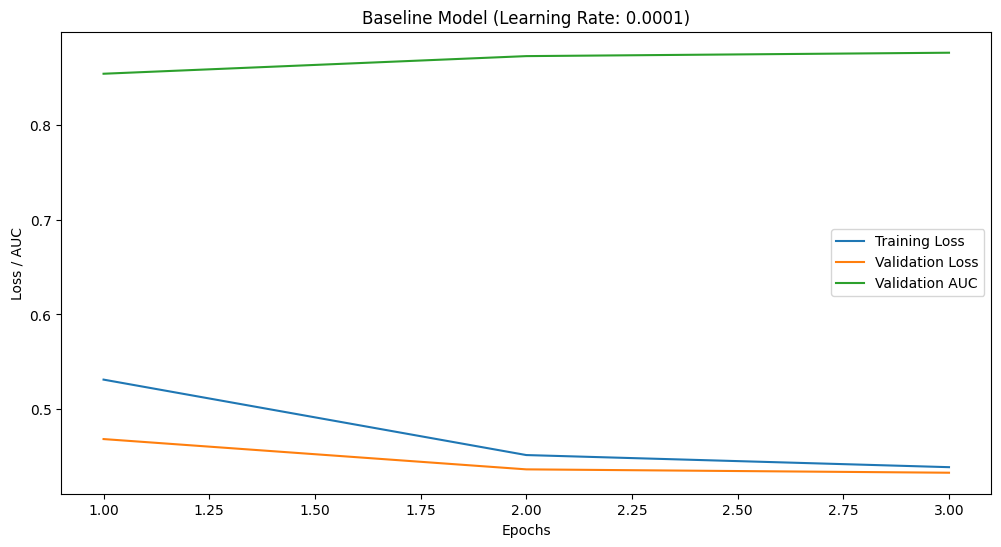

In [11]:
# Train the baseline model with different learning rates
learning_rates = [0.01, 0.001, 0.0001]
baseline_results = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define loss function
criterion = nn.BCEWithLogitsLoss() # Using logits for numerical stability

for lr in learning_rates:
    print(f"\nTraining Baseline Model with learning rate: {lr}")
    baseline_model = BaselineCNN()  # Reinitialize the model
    optimizer = optim.Adam(baseline_model.parameters(), lr=lr)
    baseline_results[lr] = train_and_evaluate(baseline_model, train_loader, val_loader, criterion, optimizer, epochs=3)

# Plot results for different learning rates
for lr, results in baseline_results.items():
    print(f"\nResults for Learning Rate {lr}:")
    plot_results(results, f"Baseline Model (Learning Rate: {lr})")

### Enhanced CNN Model

Using device: cuda

Training Enhanced Model with dropout rate: 0.2
Epoch 1/3 - Training:
  Batch 10/344 - Loss: 0.6907
  Batch 20/344 - Loss: 0.6011
  Batch 30/344 - Loss: 0.5514
  Batch 40/344 - Loss: 0.4849
  Batch 50/344 - Loss: 0.4481
  Batch 60/344 - Loss: 0.5161
  Batch 70/344 - Loss: 0.4501
  Batch 80/344 - Loss: 0.4913
  Batch 90/344 - Loss: 0.4627
  Batch 100/344 - Loss: 0.4184
  Batch 110/344 - Loss: 0.4528
  Batch 120/344 - Loss: 0.4457
  Batch 130/344 - Loss: 0.4192
  Batch 140/344 - Loss: 0.4552
  Batch 150/344 - Loss: 0.4483
  Batch 160/344 - Loss: 0.4250
  Batch 170/344 - Loss: 0.4667
  Batch 180/344 - Loss: 0.4389
  Batch 190/344 - Loss: 0.4312
  Batch 200/344 - Loss: 0.4511
  Batch 210/344 - Loss: 0.4273
  Batch 220/344 - Loss: 0.4455
  Batch 230/344 - Loss: 0.4618
  Batch 240/344 - Loss: 0.4595
  Batch 250/344 - Loss: 0.4471
  Batch 260/344 - Loss: 0.4313
  Batch 270/344 - Loss: 0.4531
  Batch 280/344 - Loss: 0.4334
  Batch 290/344 - Loss: 0.4190
  Batch 300/344 - Los

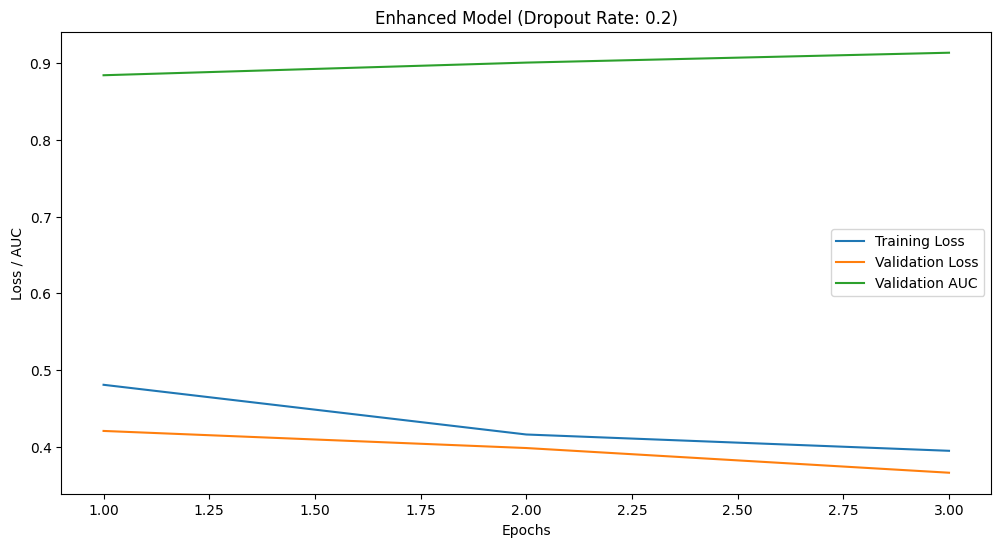


Results for Dropout Rate 0.3:


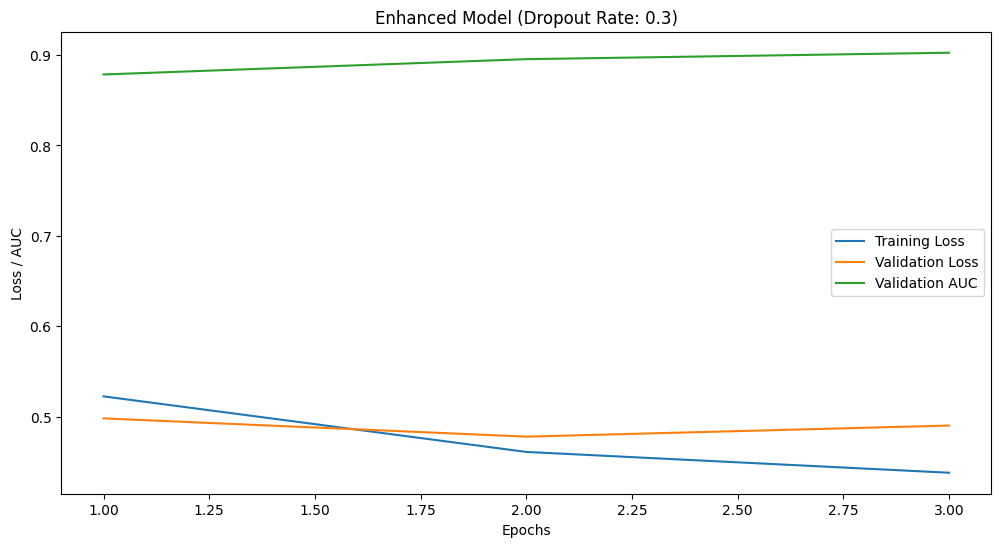


Results for Dropout Rate 0.4:


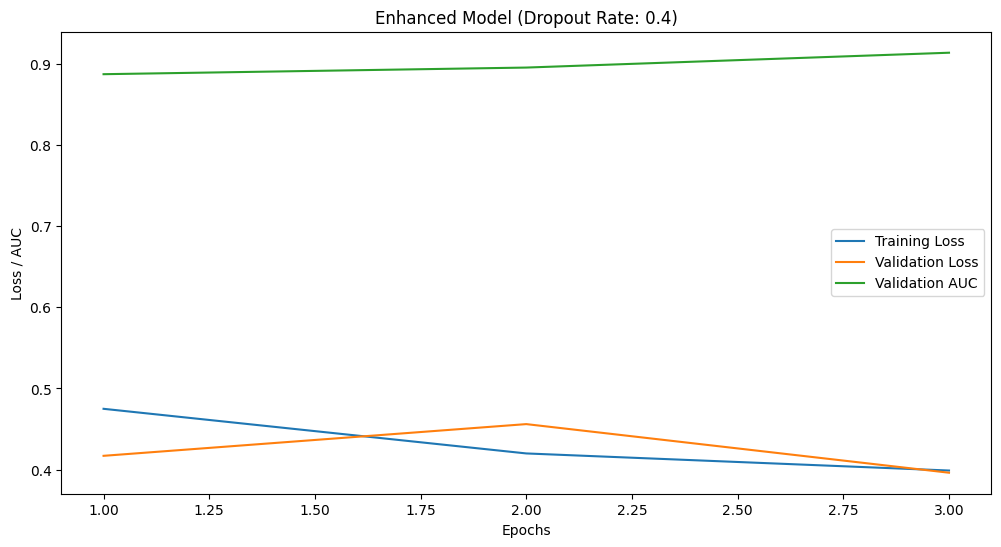

In [12]:
# Train the enhanced model with different dropout rates
dropout_rates = [0.2, 0.3, 0.4]
enhanced_results = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
baseline_model.to(device)
print(f"Using device: {device}")

# Define loss function
criterion = nn.BCEWithLogitsLoss() # Using logits for numerical stability

for dropout in dropout_rates:
    print(f"\nTraining Enhanced Model with dropout rate: {dropout}")

    class EnhancedCNN(nn.Module):
        def __init__(self):
            super(EnhancedCNN, self).__init__()
            self.conv_layers = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Dropout(dropout),  # Apply dynamic dropout rate
                
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Dropout(dropout),
                
                nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Dropout(dropout),
            )
            self.fc_layers = nn.Sequential(
                nn.Flatten(),
                nn.Linear(128 * 4 * 4, 256),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(256, 1),
            )
        
        def forward(self, x):
            x = self.conv_layers(x)
            x = self.fc_layers(x)
            return x
    
    # Initialize the model
    enhanced_model = EnhancedCNN()
    optimizer = optim.Adam(enhanced_model.parameters(), lr=0.001)
    enhanced_results[dropout] = train_and_evaluate(enhanced_model, train_loader, val_loader, criterion, optimizer, epochs=3)

# Plot results for different dropout rates
for dropout, results in enhanced_results.items():
    print(f"\nResults for Dropout Rate {dropout}:")
    plot_results(results, f"Enhanced Model (Dropout Rate: {dropout})")

We build on top of the baseline version of the CNN to make it slightly more complex , to see if adding more complexity helps to generalize the model better.

**Architecture:**


* Three convolutional layers to capture hierarchical features
* Batch Normalization for stabilizing training and improving convergence
* Dropout layers for regularization, reducing overfitting
* Fully connected layers with an additional hidden layer


**Reasoning:**
In this model, we increase the depth of the network by adding more convolution layers, so that extract features better.
To help model stabalize and generalize, we also use batchnorm and dropout layers.

### Transfer Learning
Finally, lets also see if we can utilize the pre-existing knowledge of a model traning on one dataset and fine tune it for our dataset to produce better results. In this case we will be using ResNet with pre-trained weights and then experiment with fine tuning final few layers for our own dataset.

Using device: cuda

Training Transfer Learning Model fine-tuning 1 layers


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 204MB/s]


Epoch 1/3 - Training:
  Batch 10/344 - Loss: 0.7171
  Batch 20/344 - Loss: 0.7047
  Batch 30/344 - Loss: 0.7223
  Batch 40/344 - Loss: 0.7175
  Batch 50/344 - Loss: 0.6983
  Batch 60/344 - Loss: 0.6974
  Batch 70/344 - Loss: 0.6636
  Batch 80/344 - Loss: 0.6780
  Batch 90/344 - Loss: 0.6612
  Batch 100/344 - Loss: 0.6609
  Batch 110/344 - Loss: 0.6675
  Batch 120/344 - Loss: 0.6624
  Batch 130/344 - Loss: 0.6646
  Batch 140/344 - Loss: 0.6338
  Batch 150/344 - Loss: 0.6455
  Batch 160/344 - Loss: 0.6204
  Batch 170/344 - Loss: 0.6219
  Batch 180/344 - Loss: 0.6257
  Batch 190/344 - Loss: 0.6283
  Batch 200/344 - Loss: 0.6426
  Batch 210/344 - Loss: 0.6318
  Batch 220/344 - Loss: 0.6204
  Batch 230/344 - Loss: 0.6068
  Batch 240/344 - Loss: 0.6308
  Batch 250/344 - Loss: 0.6564
  Batch 260/344 - Loss: 0.6481
  Batch 270/344 - Loss: 0.6028
  Batch 280/344 - Loss: 0.6103
  Batch 290/344 - Loss: 0.5985
  Batch 300/344 - Loss: 0.6129
  Batch 310/344 - Loss: 0.6086
  Batch 320/344 - Loss: 0.

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/3 - Training:
  Batch 10/344 - Loss: 0.6176
  Batch 20/344 - Loss: 0.6052
  Batch 30/344 - Loss: 0.5203
  Batch 40/344 - Loss: 0.5670
  Batch 50/344 - Loss: 0.5486
  Batch 60/344 - Loss: 0.5542
  Batch 70/344 - Loss: 0.5493
  Batch 80/344 - Loss: 0.5270
  Batch 90/344 - Loss: 0.5618
  Batch 100/344 - Loss: 0.4903
  Batch 110/344 - Loss: 0.5367
  Batch 120/344 - Loss: 0.5480
  Batch 130/344 - Loss: 0.5533
  Batch 140/344 - Loss: 0.5439
  Batch 150/344 - Loss: 0.5114
  Batch 160/344 - Loss: 0.5588
  Batch 170/344 - Loss: 0.5039
  Batch 180/344 - Loss: 0.5124
  Batch 190/344 - Loss: 0.5273
  Batch 200/344 - Loss: 0.5202
  Batch 210/344 - Loss: 0.5077
  Batch 220/344 - Loss: 0.5015
  Batch 230/344 - Loss: 0.5180
  Batch 240/344 - Loss: 0.5139
  Batch 250/344 - Loss: 0.4924
  Batch 260/344 - Loss: 0.5229
  Batch 270/344 - Loss: 0.5336
  Batch 280/344 - Loss: 0.5453
  Batch 290/344 - Loss: 0.5211
  Batch 300/344 - Loss: 0.5778
  Batch 310/344 - Loss: 0.5153
  Batch 320/344 - Loss: 0.

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/3 - Training:
  Batch 10/344 - Loss: 0.6087
  Batch 20/344 - Loss: 0.5540
  Batch 30/344 - Loss: 0.5105
  Batch 40/344 - Loss: 0.5168
  Batch 50/344 - Loss: 0.4971
  Batch 60/344 - Loss: 0.4883
  Batch 70/344 - Loss: 0.5484
  Batch 80/344 - Loss: 0.4845
  Batch 90/344 - Loss: 0.5272
  Batch 100/344 - Loss: 0.5232
  Batch 110/344 - Loss: 0.5292
  Batch 120/344 - Loss: 0.4876
  Batch 130/344 - Loss: 0.4921
  Batch 140/344 - Loss: 0.5122
  Batch 150/344 - Loss: 0.5180
  Batch 160/344 - Loss: 0.5254
  Batch 170/344 - Loss: 0.4787
  Batch 180/344 - Loss: 0.4153
  Batch 190/344 - Loss: 0.4513
  Batch 200/344 - Loss: 0.5340
  Batch 210/344 - Loss: 0.4763
  Batch 220/344 - Loss: 0.5198
  Batch 230/344 - Loss: 0.4681
  Batch 240/344 - Loss: 0.4621
  Batch 250/344 - Loss: 0.4644
  Batch 260/344 - Loss: 0.4763
  Batch 270/344 - Loss: 0.4890
  Batch 280/344 - Loss: 0.4382
  Batch 290/344 - Loss: 0.4839
  Batch 300/344 - Loss: 0.4851
  Batch 310/344 - Loss: 0.4840
  Batch 320/344 - Loss: 0.

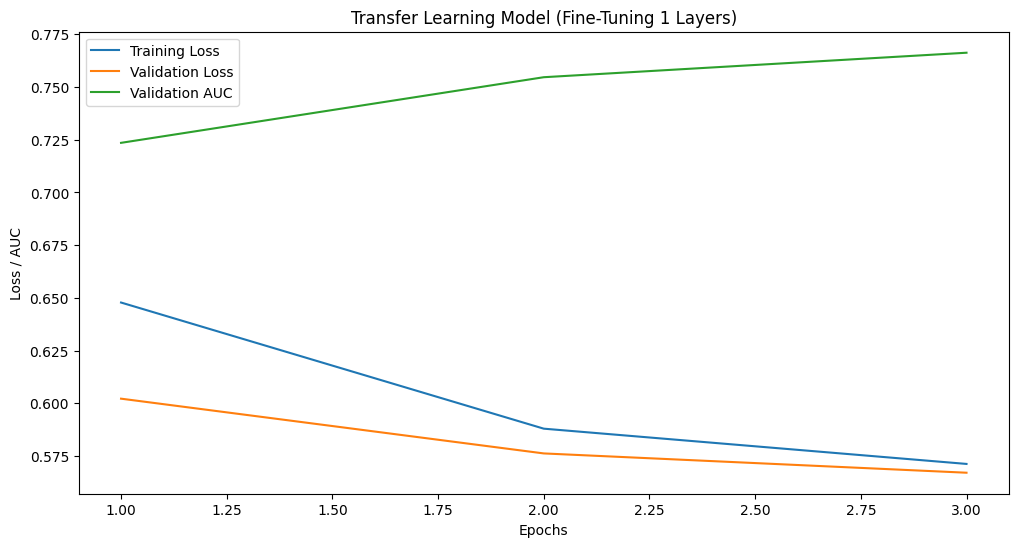


Results for Fine-Tuning 5 Layers:


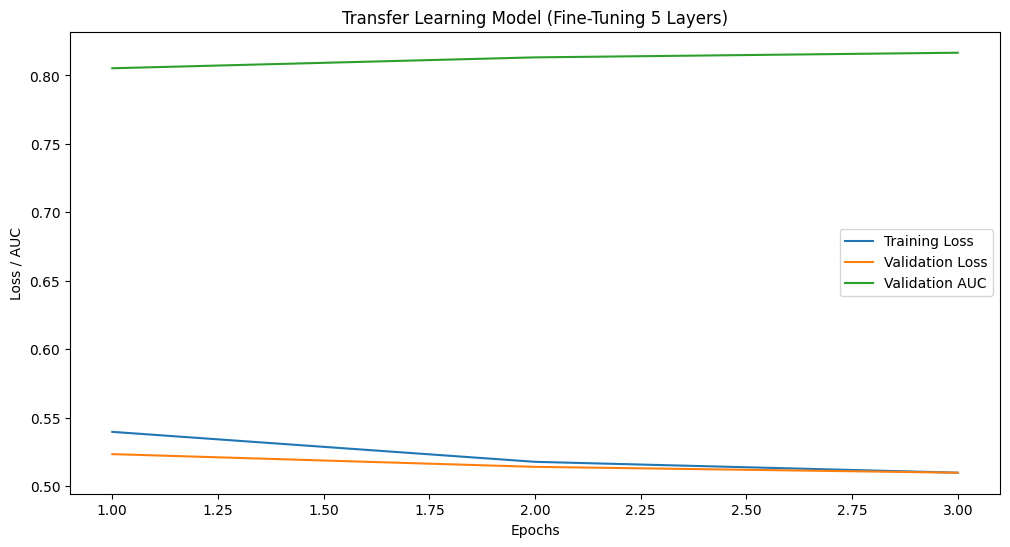


Results for Fine-Tuning 10 Layers:


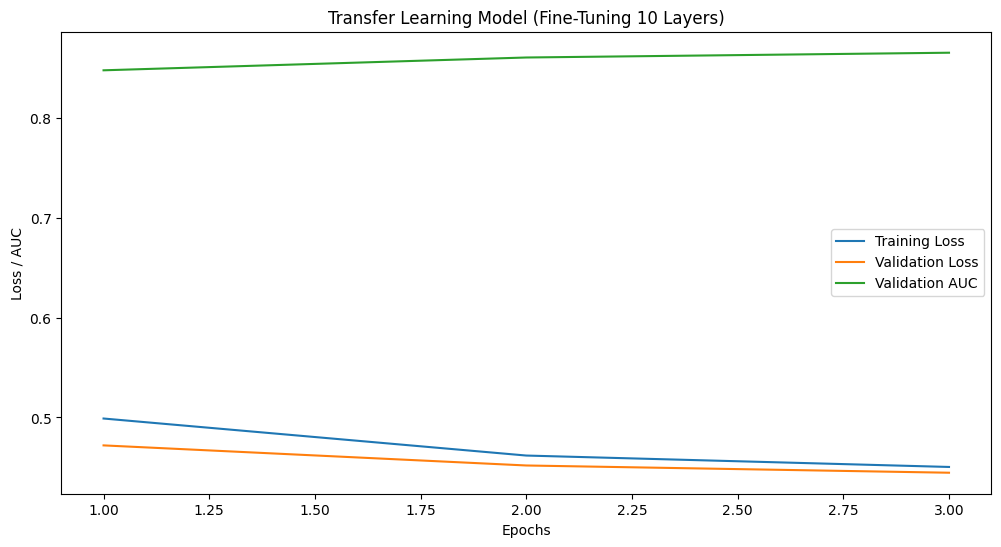

In [14]:
# Train the ResNet model with different fine-tuning configurations
from torchvision.models import resnet18
fine_tune_layers = [1, 5, 10]  # Number of final layers to fine-tune
transfer_results = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
baseline_model.to(device)
print(f"Using device: {device}")
# Define loss function
criterion = nn.BCEWithLogitsLoss() # Using logits for numerical stability

for num_layers in fine_tune_layers:
    print(f"\nTraining Transfer Learning Model fine-tuning {num_layers} layers")
    
    # Define a Transfer Learning model
    class TransferLearningModel(nn.Module):
        def __init__(self, fine_tune_layers):
            super(TransferLearningModel, self).__init__()
            self.base_model = resnet18(pretrained=True)
            for name, param in list(self.base_model.named_parameters())[:-fine_tune_layers]:
                param.requires_grad = False  # Freeze all but the last 'num_layers'
            self.base_model.fc = nn.Linear(512, 1)  # Replace the final layer for binary classification
        
        def forward(self, x):
            return self.base_model(x)
    
    # initialize the model
    transfer_model = TransferLearningModel(num_layers)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, transfer_model.parameters()), lr=0.0001)
    transfer_results[num_layers] = train_and_evaluate(transfer_model, train_loader, val_loader, criterion, optimizer, epochs=3)

# Plot results for different fine-tuning configurations
for num_layers, results in transfer_results.items():
    print(f"\nResults for Fine-Tuning {num_layers} Layers:")
    plot_results(results, f"Transfer Learning Model (Fine-Tuning {num_layers} Layers)")

**Reasoning:**
Fine-tuning controls how much the pre-trained model is adapted to the histopathology dataset.
Freezing fewer layers retains more pre-trained features, while fine-tuning more layers provides better task-specific adaptation.

## Comparision and Conclusion of Different Models

Baseline Model Comparison:


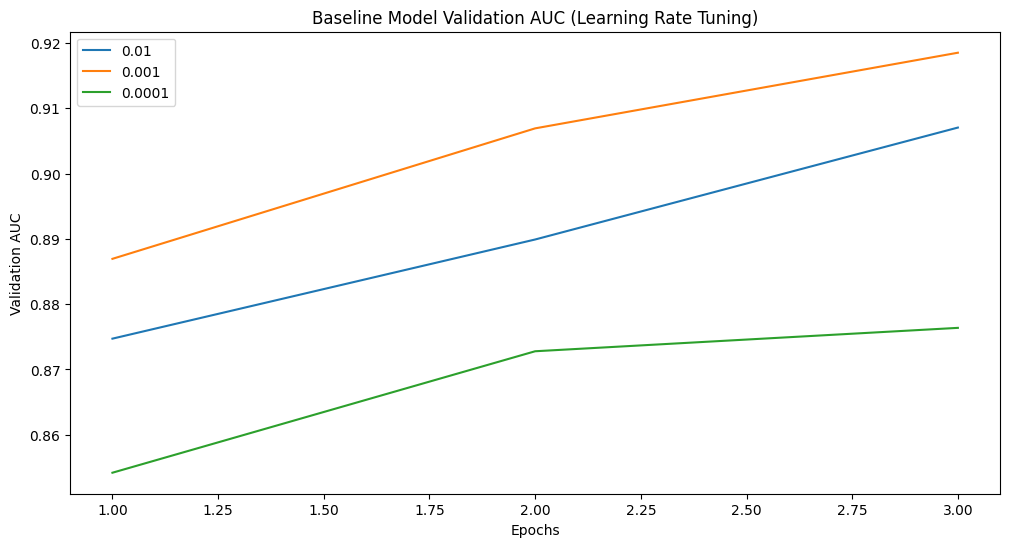

Enhanced Model Comparison:


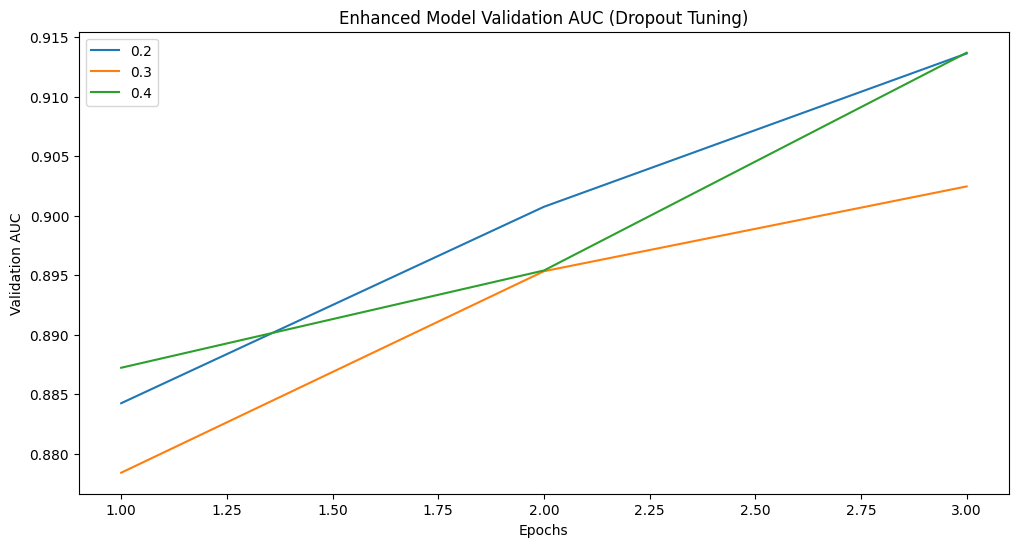

Transfer Learning Model Comparison:


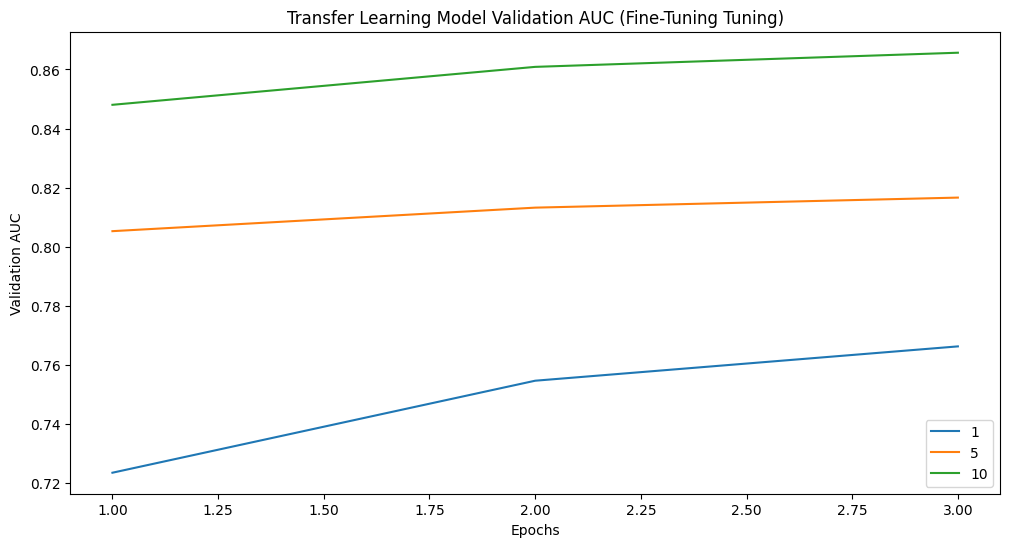

In [15]:
# Compare validation AUC scores across models
def compare_models(results_dict, title):
    plt.figure(figsize=(12, 6))
    for label, results in results_dict.items():
        _, _, val_aucs = results
        plt.plot(range(1, len(val_aucs) + 1), val_aucs, label=f"{label}")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Validation AUC")
    plt.legend()
    plt.show()

print("Baseline Model Comparison:")
compare_models(baseline_results, "Baseline Model Validation AUC (Learning Rate Tuning)")

print("Enhanced Model Comparison:")
compare_models(enhanced_results, "Enhanced Model Validation AUC (Dropout Tuning)")

print("Transfer Learning Model Comparison:")
compare_models(transfer_results, "Transfer Learning Model Validation AUC (Fine-Tuning Tuning)")

### Conclusion

There are some interesting observations here:
1. We can see from the above graph that the enhanced model worked the best in terms of ROC AUC scores. This is surprising considering one owould hope the pretrained and finetuned ResNet model would perform much better due to its superior architecture. However, this might be because the ResNet model is trained over imageNet data which is inherently different that medical imaging data like we have here. This means that its perfectly resonable to assume , the pre-training of ResNet model did not help.
2. On the other hand, the enhancements made in the 2nd model like adding more depth and experimenting with regularization and batchnorm definitely helped the model to extract better features.
3. It should also be noted that due to limited time and compute resources, the training for all three models was done only until epoch 3. Extending the training for more epocs should produce better results.
4. We also experimented with different hyperparameters, but not all on the same model, this was done to limit the training time. Tuning all these parameters for the best performing model should yeild better results.
5. With the 3 epochs worth of training, it seems like the learning rate of 0.01 seems to be converging faster. Also for the 2nd enhanced model, it seems both dropout of 0.2 and 0.4 seems to be performing well. However, both the models need to be traned for additional epochs to make a fair conclusion.
6. As for transfer learning, it seems the model where more number of layers are retuned seems to perform better, which corroborates the first point that pre-training does not really help for this particular problem. May be using a pre-training model from medical imaging feild would perform much better.

## Prepare Kaggle submission file for test set

In [25]:
# Create dummy input of the same size as the test images
dummy_input = torch.randn(1, 3, 32, 32).to(device)  # (batch_size=1, channels=3, height=32, width=32)

# Pass the dummy input through the convolutional layers
dummy_output = enhanced_model.conv_layers(dummy_input)
print(dummy_output.shape)  # Check the output shape

torch.Size([1, 128, 4, 4])


In [30]:
# Define the dataset class for the test set
class HistopathologicTestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.test_dir = test_dir
        self.image_ids = os.listdir(test_dir)  # List of all test image files
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_name = self.image_ids[idx]
        img_path = os.path.join(self.test_dir, img_name)
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image, img_name.split(".")[0]  # Return image and its ID (without extension)

# Define the same transformation pipeline as for training (but without augmentation)
test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.8, 0.8, 0.8], std=[0.2, 0.2, 0.2])  # Normalization
])

# Create the test dataset and DataLoader
test_dir = '/kaggle/input/histopathologic-cancer-detection/test'
test_dataset = HistopathologicTestDataset(test_dir=test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=4, pin_memory=True)

enhanced_model.eval()
# Generate predictions for the test set
predictions = []
with torch.no_grad():
    for images, image_ids in test_loader:
        images = images.to(device)
        # print(images.shape)
        print(f"Image batch shape: {images.shape}")
        print(f"Image batch device: {images.device}")
        outputs = enhanced_model(images)
        probs = torch.sigmoid(outputs).squeeze(1)  # Apply sigmoid for probabilities
        predictions.extend(zip(image_ids, probs.cpu().numpy()))

# Create a submission DataFrame
submission_df = pd.DataFrame(predictions, columns=["id", "label"])
submission_df["label"] = submission_df["label"].apply(lambda x: 1 if x > 0.5 else 0)  # Threshold for binary classification

# Save to CSV for submission
submission_file = '/kaggle/working/submission.csv'
submission_df.to_csv(submission_file, index=False)

print(f"Submission file saved to {submission_file}")

Image batch shape: torch.Size([512, 3, 32, 32])
Image batch device: cuda:0
Image batch shape: torch.Size([512, 3, 32, 32])
Image batch device: cuda:0
Image batch shape: torch.Size([512, 3, 32, 32])
Image batch device: cuda:0
Image batch shape: torch.Size([512, 3, 32, 32])
Image batch device: cuda:0
Image batch shape: torch.Size([512, 3, 32, 32])
Image batch device: cuda:0
Image batch shape: torch.Size([512, 3, 32, 32])
Image batch device: cuda:0
Image batch shape: torch.Size([512, 3, 32, 32])
Image batch device: cuda:0
Image batch shape: torch.Size([512, 3, 32, 32])
Image batch device: cuda:0
Image batch shape: torch.Size([512, 3, 32, 32])
Image batch device: cuda:0
Image batch shape: torch.Size([512, 3, 32, 32])
Image batch device: cuda:0
Image batch shape: torch.Size([512, 3, 32, 32])
Image batch device: cuda:0
Image batch shape: torch.Size([512, 3, 32, 32])
Image batch device: cuda:0
Image batch shape: torch.Size([512, 3, 32, 32])
Image batch device: cuda:0
Image batch shape: torch.